In [12]:
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
import sys
import logging

# numpy
import numpy

# random
from random import shuffle

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
import os
import pymorphy2

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Я руководствовалась в работе вот этим постом: http://linanqiu.github.io/2015/10/07/word2vec-sentiment/

## Начнем с предобработки. В итоге я должна получить 6 текстовых файлов:
- test_anec.txt
- test_izvest.txt
- test_tech.txt
- train_anec.txt
- train_izvest.txt
- train_tech.txt

Так как датасет сбалансирован по классам, ничего обрезать мне не пришлось. В каждом тренировочном файле по 98 документов коллекции соответствующего жанра,
в каждом тестовом - по 27. В файле каждый документ должен располагаться на отдельной строке, в строке - список лемм через пробел
с удаленными стоп-словами и знаками препинания. Сейчас мы этим как раз займемся.

In [3]:
cachedStopWords = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [5]:
punct = '”“".,«»\\/*!:;—()\'-%`.?―[]*-'

In [6]:
def preprocess(dir_name, result_f):
    files = os.listdir('./' + dir_name)
    result = ''
    for i in range(len(files)):
        file = files[i]
        if file.endswith('.txt'):
            result += string(os.path.join('./' + dir_name, file)) + '\n'
            if i == 99:
                train = result
                result = ''
    with open('test_' + result_f, 'w', encoding='utf-8') as j:
        j.write(result)
    with open('train_' + result_f, 'w', encoding='utf-8') as f:
        f.write(train)

In [7]:
def string(text):
    g = open(text, 'r')
    arr = []
    for line in g:
        line = line.strip().lower().split()
        for word in line:
            word = word.strip(punct).lstrip(punct)
            word = word.strip(punct)
            word = word.strip(punct)
            lemma = morph.parse(word)[0].normal_form
            if len(lemma) > 0:
                if lemma not in cachedStopWords and lemma[0] not in punct:
                    arr.append(lemma)
    g.close()
    return ' '.join(arr)                                 

In [8]:
lets_see = preprocess('anekdots', 'anec.txt')

In [9]:
second = preprocess('izvest', 'izvest.txt')

In [10]:
third = preprocess('teh_mol', 'tech.txt')

## Теперь скармливаем данные doc2vec

In [26]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffle(self.sentences)
        return self.sentences

In [27]:
sources = {'test_anec.txt':'TEST_ANEC',
           'test_izvest.txt':'TEST_IZVEST',
           'test_tech.txt':'TEST_TECH',
           'train_anec.txt':'TRAIN_ANEC',
           'train_izvest.txt':'TRAIN_IZVEST',
           'train_tech.txt':'TRAIN_TECH'}

sentences = LabeledLineSentence(sources)

In [28]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=8)
model.build_vocab(sentences.to_array())

# Теперь натренируем модель и сохраним её

In [29]:
for epoch in range(10):
    model.train(sentences.sentences_perm())
model.save('./russian_texts.d2v')

In [2]:
model = Doc2Vec.load('./russian_texts.d2v')

2017-03-29 20:00:28,333 : INFO : loading Doc2Vec object from ./russian_texts.d2v
2017-03-29 20:00:28,769 : INFO : loading docvecs recursively from ./russian_texts.d2v.docvecs.* with mmap=None
2017-03-29 20:00:28,770 : INFO : loading wv recursively from ./russian_texts.d2v.wv.* with mmap=None
2017-03-29 20:00:28,771 : INFO : setting ignored attribute syn0norm to None
2017-03-29 20:00:28,773 : INFO : setting ignored attribute cum_table to None
2017-03-29 20:00:28,774 : INFO : loaded ./russian_texts.d2v


In [33]:
model.docvecs.doctags

{'TEST_ANEC_0': Doctag(offset=223, word_count=3038, doc_count=1),
 'TEST_ANEC_1': Doctag(offset=224, word_count=892, doc_count=1),
 'TEST_ANEC_10': Doctag(offset=233, word_count=1401, doc_count=1),
 'TEST_ANEC_11': Doctag(offset=234, word_count=1595, doc_count=1),
 'TEST_ANEC_12': Doctag(offset=235, word_count=1599, doc_count=1),
 'TEST_ANEC_13': Doctag(offset=236, word_count=451, doc_count=1),
 'TEST_ANEC_14': Doctag(offset=237, word_count=833, doc_count=1),
 'TEST_ANEC_15': Doctag(offset=238, word_count=251, doc_count=1),
 'TEST_ANEC_16': Doctag(offset=239, word_count=426, doc_count=1),
 'TEST_ANEC_17': Doctag(offset=240, word_count=2032, doc_count=1),
 'TEST_ANEC_18': Doctag(offset=241, word_count=4643, doc_count=1),
 'TEST_ANEC_19': Doctag(offset=242, word_count=5922, doc_count=1),
 'TEST_ANEC_2': Doctag(offset=225, word_count=1498, doc_count=1),
 'TEST_ANEC_20': Doctag(offset=243, word_count=2845, doc_count=1),
 'TEST_ANEC_21': Doctag(offset=244, word_count=2047, doc_count=1),
 'T

In [36]:
model.docvecs['TRAIN_TECH_45']

array([ 0.19051854,  0.60918671, -2.38717127,  2.03238726,  7.32066965,
        1.86719906,  4.68396187, -6.67090464,  3.68699622,  0.98762316,
        1.93070221, -1.0310092 , -1.66179109, -1.3848834 ,  1.11528373,
        2.92722678, -1.21440363, -1.19559765,  1.83826792, -0.79649842,
       -3.62324762,  1.25002921, -1.513304  ,  3.97247314, -4.25109673,
       -1.24689043, -1.68420231, -0.10447729, -5.07565308, -1.83043909,
        1.32588243, -1.67528474,  0.8703478 , -0.27897906,  1.45031524,
        0.90892577, -3.98192501, -0.08950612,  0.46196195,  2.16972303,
       -1.28289986, -1.6826942 , -0.22298405, -2.38571835, -0.77140588,
        0.89957792, -5.36177444, -2.1429472 ,  2.42758512, -1.89045608,
        0.62412119, -3.92977977, -2.63474154,  2.1310513 ,  0.95864904,
        0.18055861,  2.47236037, -0.59053892, -4.24156332,  0.41244784,
       -0.15206599,  2.20668697, -1.68862784,  4.29834509,  1.14757884,
       -0.10588936,  1.84893858, -4.42485809, -2.99772143,  0.57

Теперь переходим поближе к машинному обучению. Надо сделать numpy массивы для тренировочной и проверочной выборок.

In [3]:
train_arrays = numpy.zeros((294, 100))
train_labels = numpy.zeros(294)

for i in range(98):
    prefix_train_a = 'TRAIN_ANEC_' + str(i)
    prefix_train_i = 'TRAIN_IZVEST_' + str(i)
    prefix_train_t = 'TRAIN_TECH_' + str(i)
    train_arrays[i] = model.docvecs[prefix_train_a]
    train_arrays[98 + i] = model.docvecs[prefix_train_i]
    train_arrays[98 + 98 + i] = model.docvecs[prefix_train_t]
    train_labels[i] = 0 #anekdots
    train_labels[98 + i] = 1 #izvest
    train_labels[98 + 98 + i] = 2 #teh_mol

In [4]:
print(train_labels)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2

In [5]:
test_arrays = numpy.zeros((81, 100))
test_labels = numpy.zeros(81)

for i in range(27):
    prefix_test_a = 'TEST_ANEC_' + str(i)
    prefix_test_i = 'TEST_IZVEST_' + str(i)
    prefix_test_t = 'TEST_TECH_' + str(i)
    test_arrays[i] = model.docvecs[prefix_test_a]
    test_arrays[27 + i] = model.docvecs[prefix_test_i]
    test_arrays[27 + 27 + i] = model.docvecs[prefix_test_t]
    test_labels[i] = 0 #anekdots
    test_labels[27 + i] = 1 #izvest
    test_labels[27 + 27 + i] = 2 #teh_mol

In [6]:
print(test_labels)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.]


Данные готовы. Давайте обучаться и тестироваться.

In [7]:
clf = LogisticRegression(penalty="l2", solver="lbfgs", multi_class="multinomial", max_iter=100)
clf.fit(train_arrays, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
y_pred = clf.predict(test_arrays)

In [11]:
print(classification_report(test_labels, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        27
        1.0       0.96      0.85      0.90        27
        2.0       0.87      0.96      0.91        27

avg / total       0.94      0.94      0.94        81



In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[27  0  0]
 [ 0 23  4]
 [ 0  1 26]]


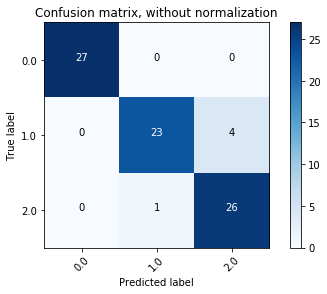

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, y_pred)
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clf.classes_,
                      title='Confusion matrix, without normalization')

plt.show()

Я сделала дефолтные n_jobs=1 в параметре классификатора, потому что со значением 4 работало несколько часов и не закончило даже. 
Получился хороший результат: f-мера 0.94. Неправильно размеченных примеров 5 всего лишь.